Benchmark Temperatura

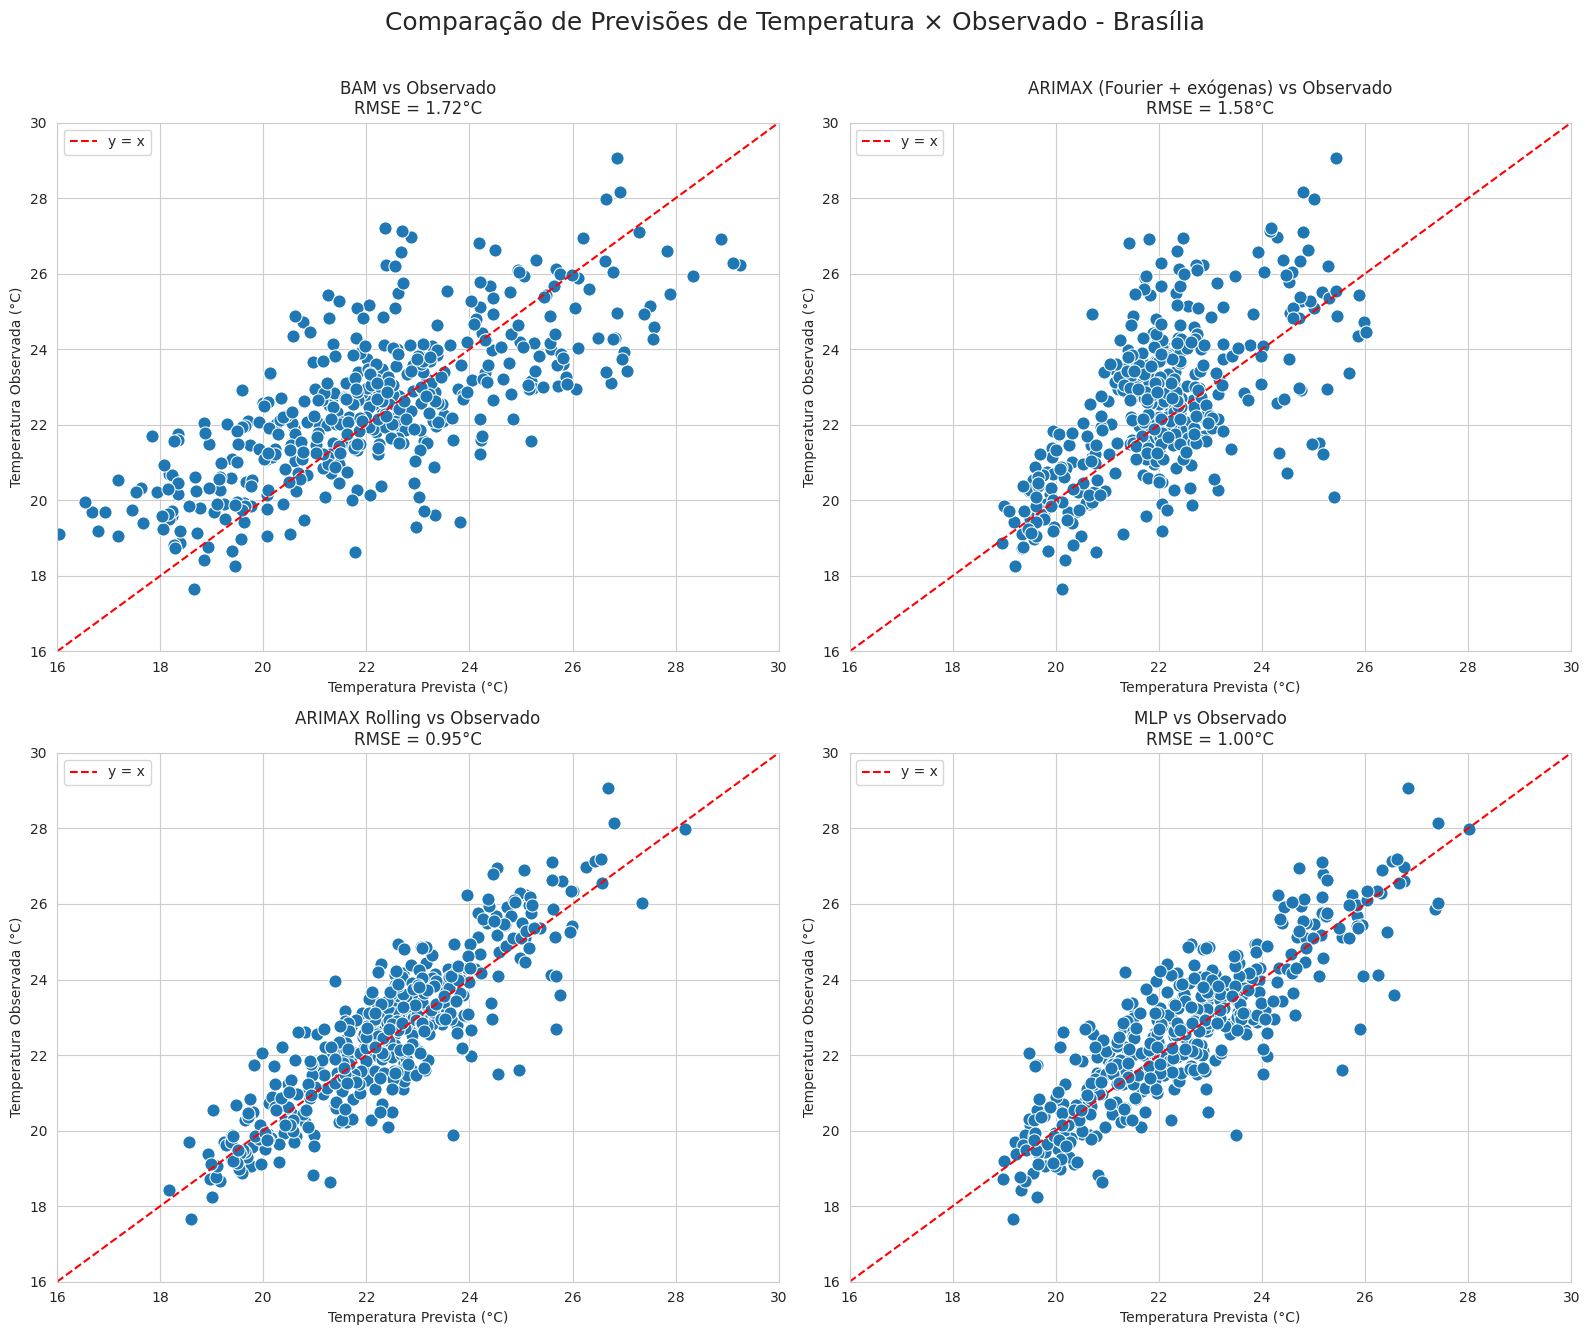

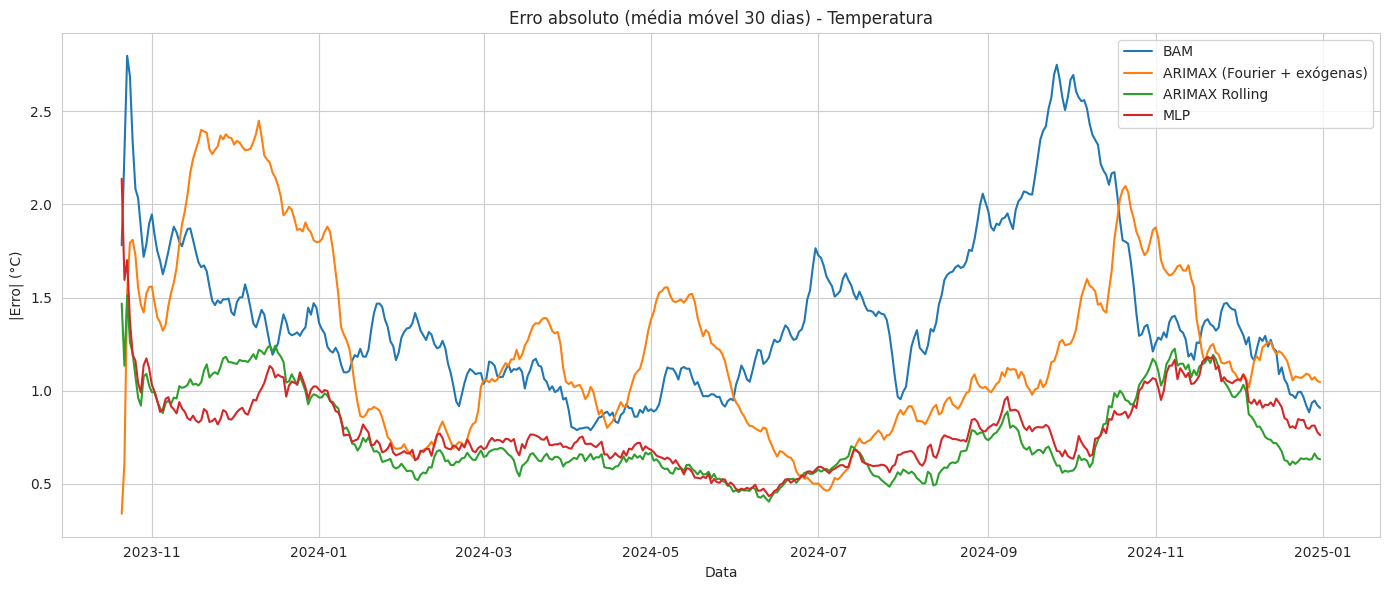

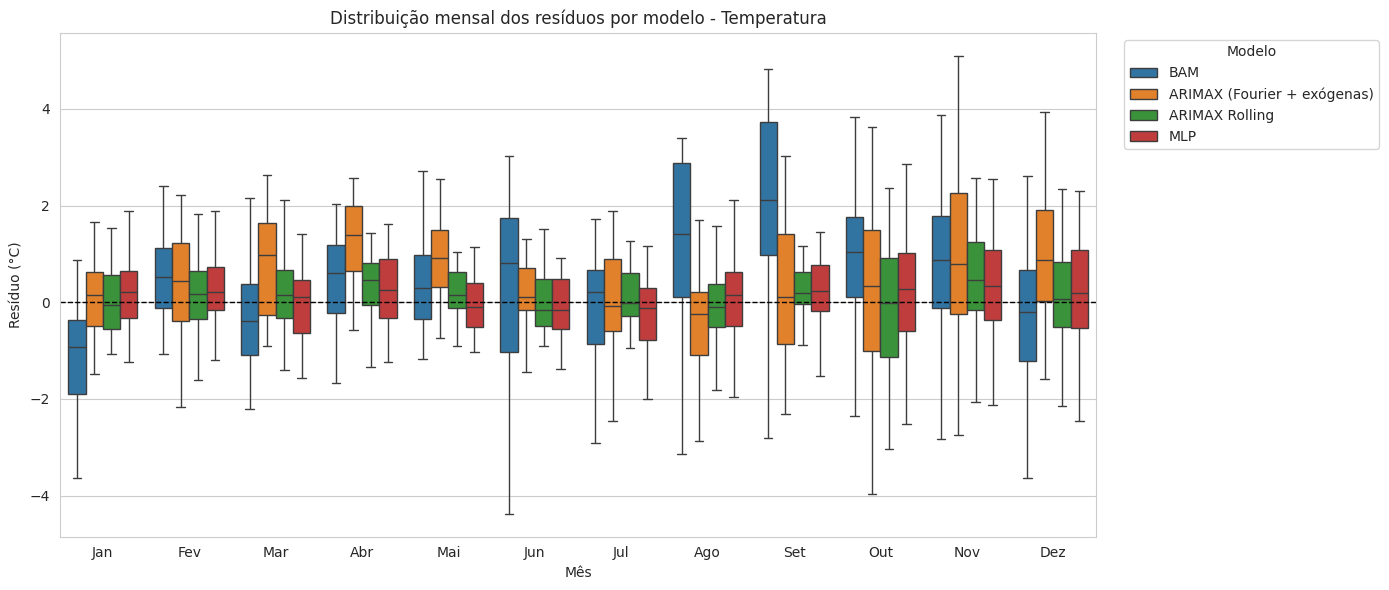

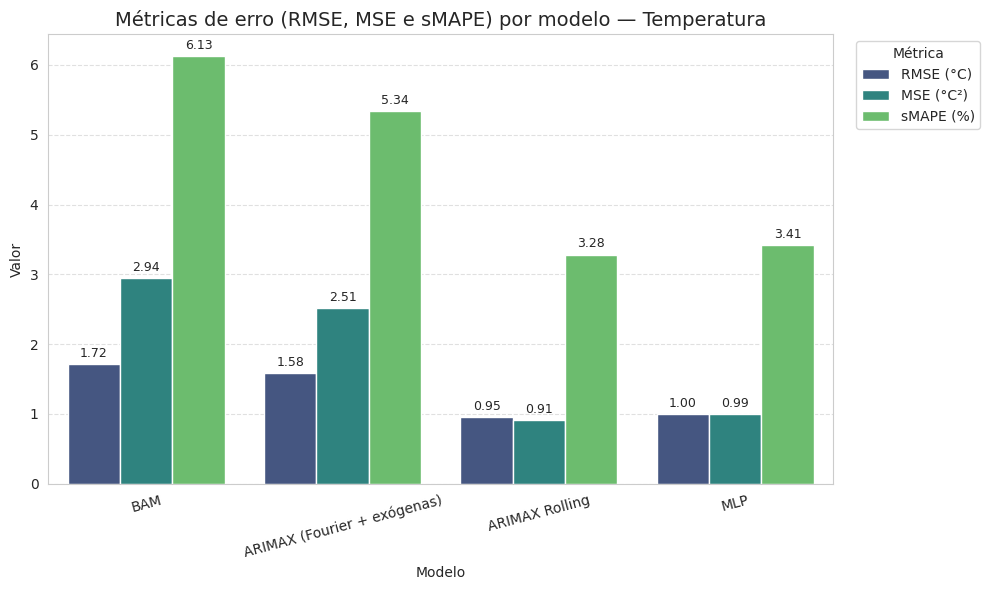

Métricas de erro por modelo:
                     Modelo  RMSE (°C)  MSE (°C²)  sMAPE (%)
                        BAM      1.715      2.943      6.132
ARIMAX (Fourier + exógenas)      1.585      2.511      5.342
             ARIMAX Rolling      0.954      0.910      3.282
                        MLP      0.997      0.993      3.414
Registros pós-merge: 438 dias
RMSE (BAM vs Obs):     1.715 °C
RMSE (Fourier vs Obs): 1.585 °C
RMSE (Fourier Exogs vs Obs): 1.585 °C
RMSE (Rolling vs Obs):  0.954 °C
RMSE (Neural Network vs Obs): 0.997 °C


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
import numpy as np

sns.set_style("whitegrid")

# Leitura dos dados
df_bam      = pd.read_csv('bam_data.csv', sep=';')
df_fourier  = pd.read_csv('forecast_arima_fourier.csv', sep=';')
df_fourier_exog = pd.read_csv('forecast_arima_fourierexog.csv', sep=';')
df_rolling  = pd.read_csv('forecast_arima_rolling.csv', sep=';')
df_mlp      = pd.read_csv('forecast_mlp.csv', sep=';')

#  Processar BAM (média diária)
df_bam['time'] = pd.to_datetime(df_bam['time'])
df_bam['date'] = df_bam['time'].dt.date
df_bam_daily = (
    df_bam.groupby('date', as_index=False)['t2m']
    .mean()
    .rename(columns={'t2m': 'temperatura_bam'})
)

# Função utilitária p/ processar previsões
def daily_from_forecast_csv(df, prefix):
    df = df.copy()
    df['date'] = pd.to_datetime(df['data']).dt.date
    return (
        df.groupby('date', as_index=False)[['temperatura_observada', 'temperatura_prevista']]
          .mean()
          .rename(columns={
              'temperatura_observada': f'temperatura_observada_{prefix}',
              'temperatura_prevista':  f'temperatura_prevista_{prefix}'
          })
    )

df_fourier_daily      = daily_from_forecast_csv(df_fourier, 'fourier')
df_fourier_exog_daily = daily_from_forecast_csv(df_fourier_exog, 'fourierexog')
df_rolling_daily      = daily_from_forecast_csv(df_rolling, 'rolling')
df_mlp_daily          = daily_from_forecast_csv(df_mlp,     'mlp')

# Merge de previsões e definição do observado
from functools import reduce
dfs_pred = [df_fourier_daily, df_fourier_exog_daily, df_rolling_daily, df_mlp_daily]
df_pred = reduce(lambda l, r: pd.merge(l, r, on='date', how='outer'), dfs_pred)

# Escolhe a coluna "observada" disponível 
df_pred['temperatura_observada'] = np.nan
for col in [
    'temperatura_observada_fourier',
    'temperatura_observada_fourierexog',
    'temperatura_observada_rolling',
    'temperatura_observada_mlp'
]:
    if col in df_pred.columns:
        df_pred['temperatura_observada'] = df_pred['temperatura_observada'].fillna(df_pred[col])

df_pred = df_pred[['date', 'temperatura_observada',
                   'temperatura_prevista_fourier',
                   'temperatura_prevista_fourierexog',
                   'temperatura_prevista_rolling',
                   'temperatura_prevista_mlp']]

# Merge com dados BAM
df_merged = pd.merge(df_bam_daily, df_pred, on='date', how='inner').dropna()
df_merged['date'] = pd.to_datetime(df_merged['date'])
df_merged = df_merged.sort_values('date')

# Cálculo do RMSE por modelo
rmse_bam          = np.sqrt(mean_squared_error(df_merged['temperatura_observada'], df_merged['temperatura_bam']))
rmse_fourier      = np.sqrt(mean_squared_error(df_merged['temperatura_observada'], df_merged['temperatura_prevista_fourier']))
rmse_fourier_exog = np.sqrt(mean_squared_error(df_merged['temperatura_observada'], df_merged['temperatura_prevista_fourierexog']))
rmse_rolling      = np.sqrt(mean_squared_error(df_merged['temperatura_observada'], df_merged['temperatura_prevista_rolling']))
rmse_mlp          = np.sqrt(mean_squared_error(df_merged['temperatura_observada'], df_merged['temperatura_prevista_mlp']))

cols_range = ['temperatura_bam', 'temperatura_prevista_fourier', 'temperatura_prevista_fourierexog',
              'temperatura_prevista_rolling', 'temperatura_prevista_mlp', 'temperatura_observada']
min_temp = float(np.floor(df_merged[cols_range].min().min()))
max_temp = float(np.ceil(df_merged[cols_range].max().max()))

# Gráficos de dispersão 
fig, axs = plt.subplots(2, 2, figsize=(16, 14))
ax = axs.ravel()

def parity(axi, xcol, rmse, titulo):
    sns.scatterplot(data=df_merged, x=xcol, y='temperatura_observada', s=90, ax=axi)
    axi.plot([min_temp, max_temp], [min_temp, max_temp], 'r--', label='y = x')
    axi.set(xlabel='Temperatura Prevista (°C)', ylabel='Temperatura Observada (°C)',
            title=f'{titulo}\nRMSE = {rmse:.2f}°C')
    axi.legend(); axi.grid(True)
    axi.set_xlim(min_temp, max_temp); axi.set_ylim(min_temp, max_temp)

parity(ax[0], 'temperatura_bam',                  rmse_bam,          'BAM vs Observado')
parity(ax[1], 'temperatura_prevista_fourierexog', rmse_fourier_exog, 'ARIMAX (Fourier + exógenas) vs Observado')
parity(ax[2], 'temperatura_prevista_rolling',     rmse_rolling,      'ARIMAX Rolling vs Observado')
parity(ax[3], 'temperatura_prevista_mlp',         rmse_mlp,          'MLP vs Observado')

plt.suptitle('Comparação de Previsões de Temperatura × Observado - Brasília', fontsize=18)
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()

# Erro absoluto ao longo do tempo (média móvel)
roll_w = 30  # janela em dias 

# séries de erro absoluto por modelo
err_abs = {
    'BAM': (df_merged['temperatura_bam'] - df_merged['temperatura_observada']).abs(),
    'ARIMAX (Fourier + exógenas)': (df_merged['temperatura_prevista_fourierexog'] - df_merged['temperatura_observada']).abs(),
    'ARIMAX Rolling': (df_merged['temperatura_prevista_rolling'] - df_merged['temperatura_observada']).abs(),
    'MLP': (df_merged['temperatura_prevista_mlp'] - df_merged['temperatura_observada']).abs()
}

plt.figure(figsize=(14, 6))
for name, series in err_abs.items():
    # média móvel com min_periods=1 para não perder o início
    plt.plot(df_merged['date'], series.rolling(roll_w, min_periods=1).mean(), label=name)
plt.title(f'Erro absoluto (média móvel {roll_w} dias) - Temperatura')
plt.xlabel('Data'); plt.ylabel('|Erro| (°C)')
plt.grid(True); plt.legend()
plt.tight_layout(); plt.show()


# Distribuição mensal dos resíduos (boxplot)
df_merged['month_int'] = df_merged['date'].dt.month
meses_pt = ['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun', 'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez']
df_merged['Mês'] = pd.Categorical(
    df_merged['month_int'].map(lambda m: meses_pt[m-1]),
    categories=meses_pt, ordered=True
)

# calcula resíduos por modelo 
# Resíduo = Observado - Previsto (se positivo -> modelo subestimou)
residuos_df = pd.DataFrame({
    'Mês': df_merged['Mês'],
    'BAM': df_merged['temperatura_observada'] - df_merged['temperatura_bam'],
    'ARIMAX (Fourier + exógenas)': df_merged['temperatura_observada'] - df_merged['temperatura_prevista_fourierexog'],
    'ARIMAX Rolling': df_merged['temperatura_observada'] - df_merged['temperatura_prevista_rolling'],
    'MLP': df_merged['temperatura_observada'] - df_merged['temperatura_prevista_mlp']
})

residuos_long = residuos_df.melt(id_vars='Mês', var_name='Modelo', value_name='Resíduo')

plt.figure(figsize=(14, 6))
sns.boxplot(data=residuos_long, x='Mês', y='Resíduo', hue='Modelo', showfliers=False)
plt.axhline(0, ls='--', c='k', lw=1)
plt.title('Distribuição mensal dos resíduos por modelo - Temperatura')
plt.xlabel('Mês'); plt.ylabel('Resíduo (°C)')
plt.legend(title='Modelo', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Métricas globais por modelo — gráfico único com valores
# mapeamento das colunas de previsão
model_cols = {
    'BAM': 'temperatura_bam',
    'ARIMAX (Fourier + exógenas)': 'temperatura_prevista_fourierexog',
    'ARIMAX Rolling': 'temperatura_prevista_rolling',
    'MLP': 'temperatura_prevista_mlp'
}

def smape(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    denom = np.abs(y_true) + np.abs(y_pred)
    diff = np.abs(y_pred - y_true)
    with np.errstate(divide='ignore', invalid='ignore'):
        frac = np.where(denom == 0, 0.0, diff / denom)
    return 200.0 * np.nanmean(frac)  # %

# calcula métricas
metrics_global = []
for nome, col in model_cols.items():
    y_true = df_merged['temperatura_observada']
    y_pred = df_merged[col]
    mse_val  = mean_squared_error(y_true, y_pred)
    rmse_val = np.sqrt(mse_val)
    smape_val = smape(y_true, y_pred)
    metrics_global.append({
        'Modelo': nome,
        'RMSE (°C)': rmse_val,
        'MSE (°C²)': mse_val,
        'sMAPE (%)': smape_val
    })

metrics_df = pd.DataFrame(metrics_global)

metrics_long = metrics_df.melt(id_vars='Modelo', 
                               var_name='Métrica', 
                               value_name='Valor')

# Plot grafico de barras
plt.figure(figsize=(10,6))
ax = sns.barplot(data=metrics_long, x='Modelo', y='Valor', hue='Métrica', palette='viridis')

plt.title('Métricas de erro (RMSE, MSE e sMAPE) por modelo — Temperatura', fontsize=14)
plt.xlabel('Modelo')
plt.ylabel('Valor')
plt.xticks(rotation=15)
plt.legend(title='Métrica', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.grid(True, axis='y', linestyle='--', alpha=0.6)

for container in ax.containers:
    ax.bar_label(container, fmt="%.2f", padding=3, fontsize=9)

plt.tight_layout()
plt.show()

print("Métricas de erro por modelo:")
print(metrics_df.to_string(index=False, float_format="%.3f"))


print(f"Registros pós-merge: {len(df_merged)} dias")
print(f"RMSE (BAM vs Obs):     {rmse_bam:.3f} °C")
print(f"RMSE (Fourier vs Obs): {rmse_fourier:.3f} °C")
print(f"RMSE (Fourier Exogs vs Obs): {rmse_fourier_exog:.3f} °C")
print(f"RMSE (Rolling vs Obs):  {rmse_rolling:.3f} °C")
print(f"RMSE (Neural Network vs Obs): {rmse_mlp:.3f} °C")


Benchmark Precipitação

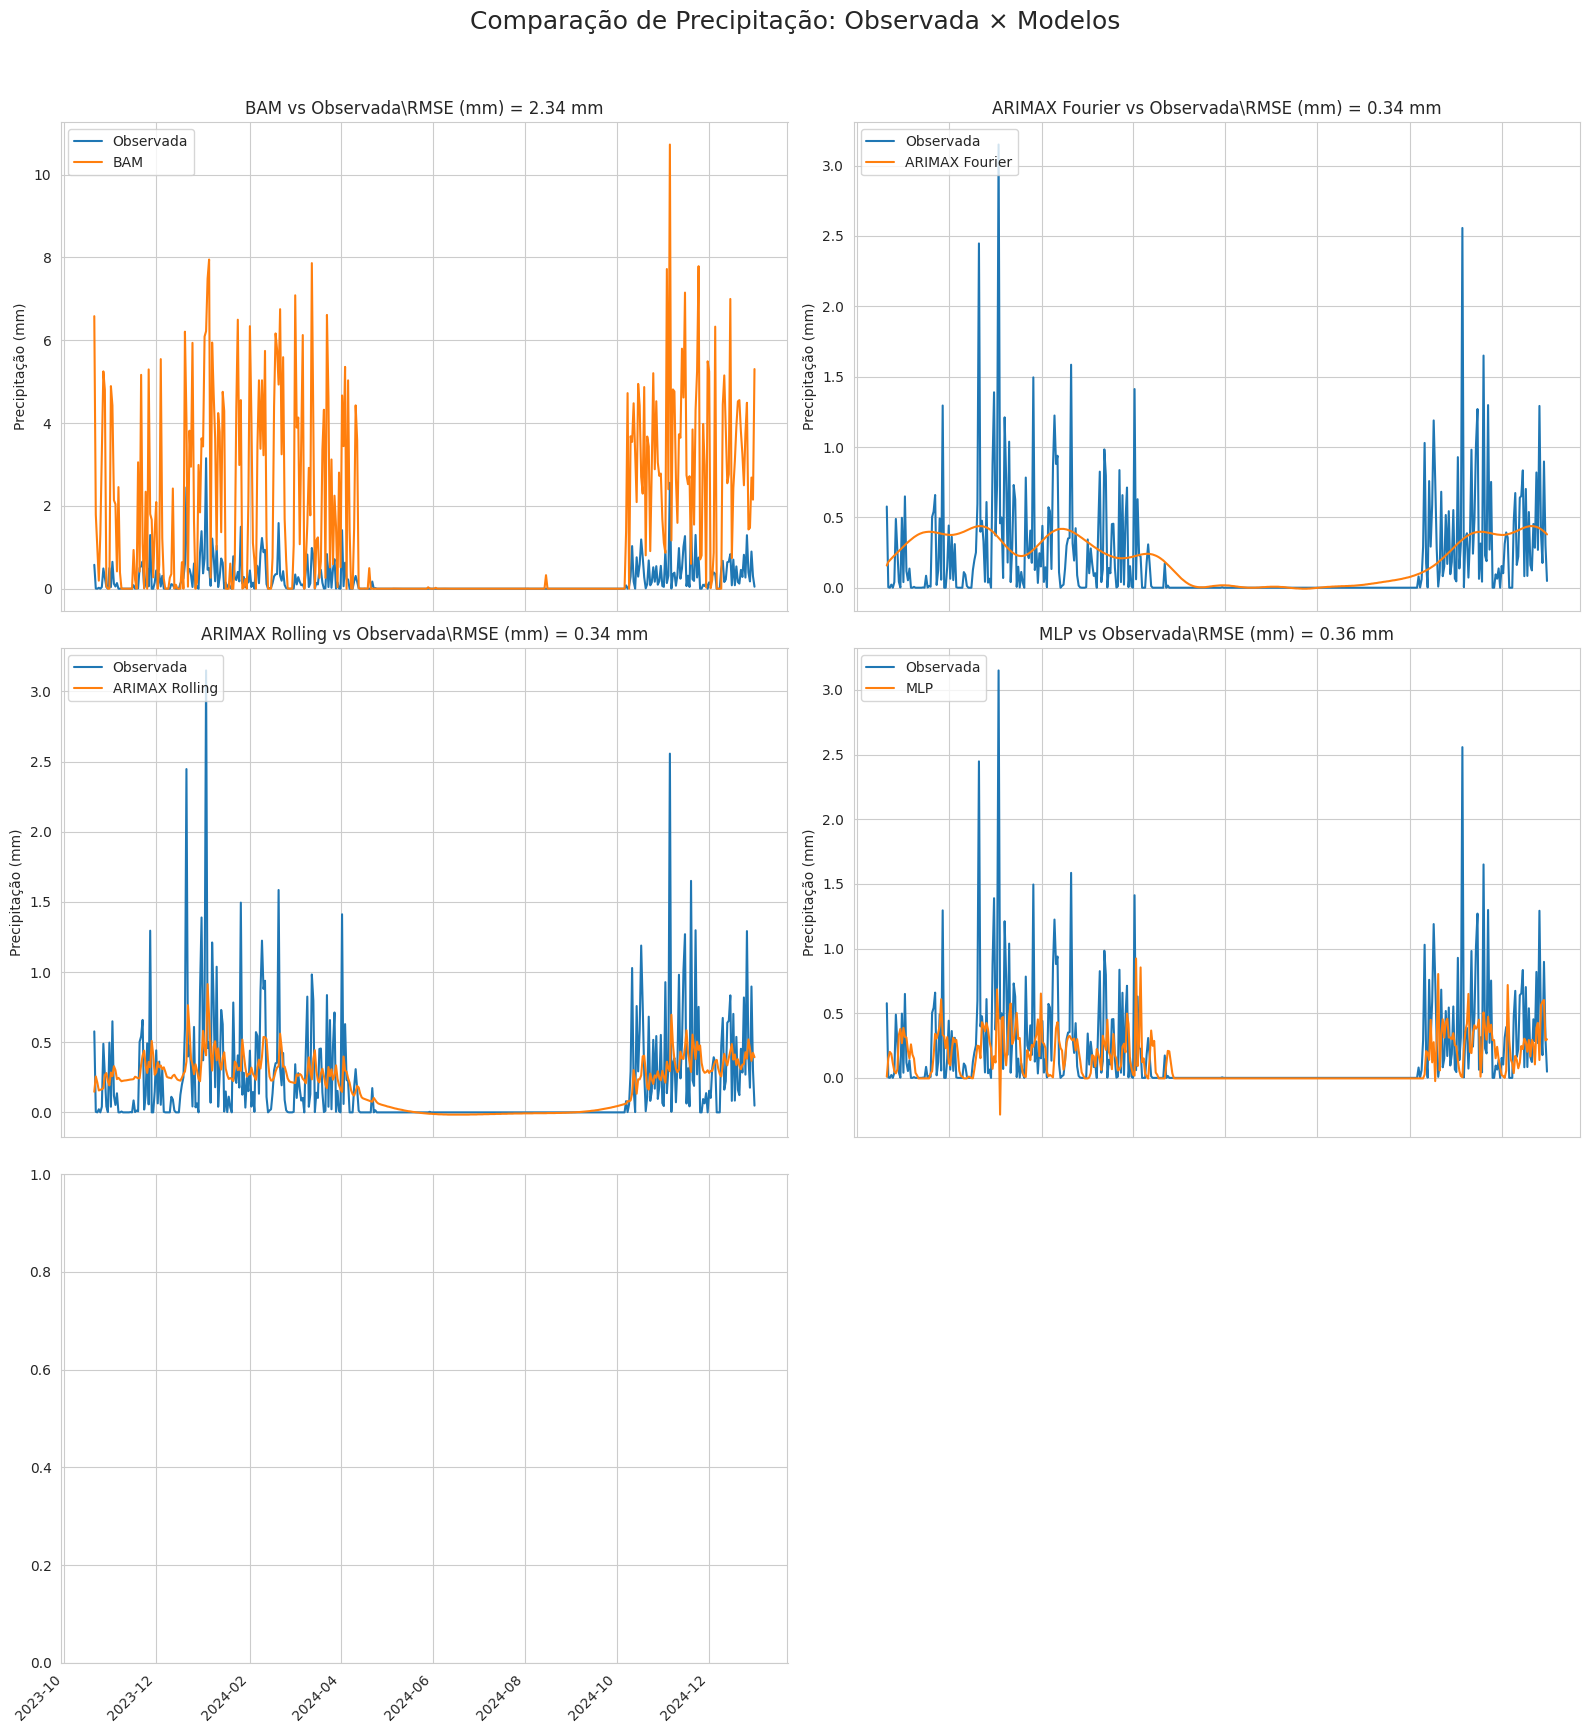

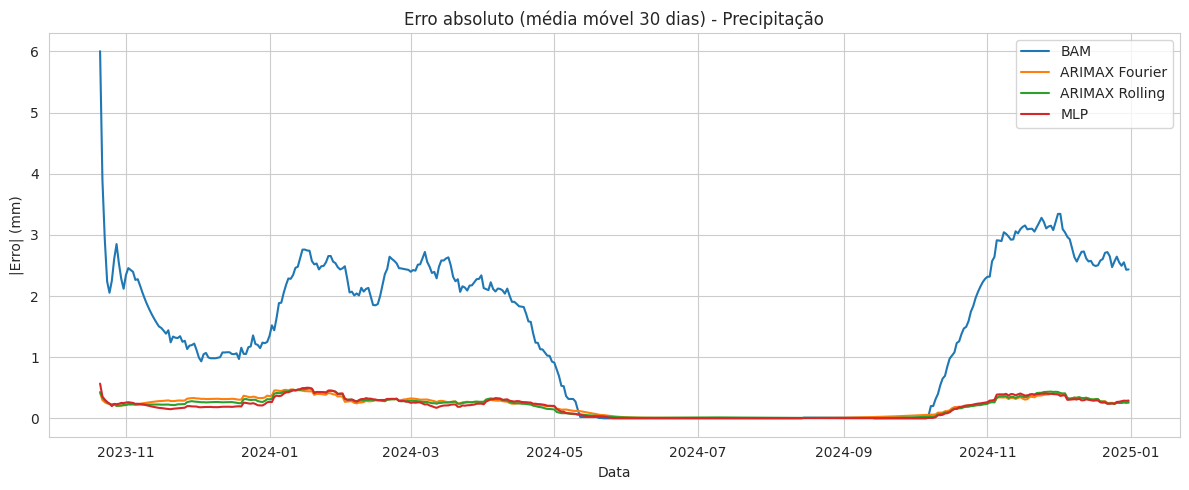

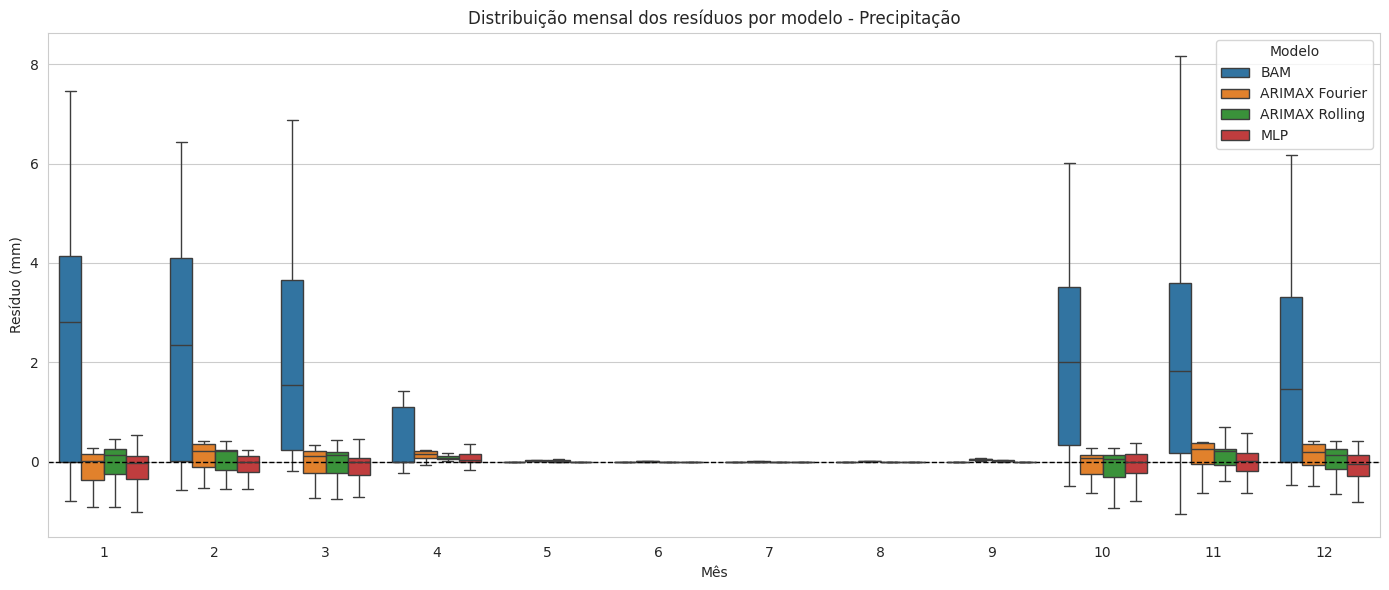

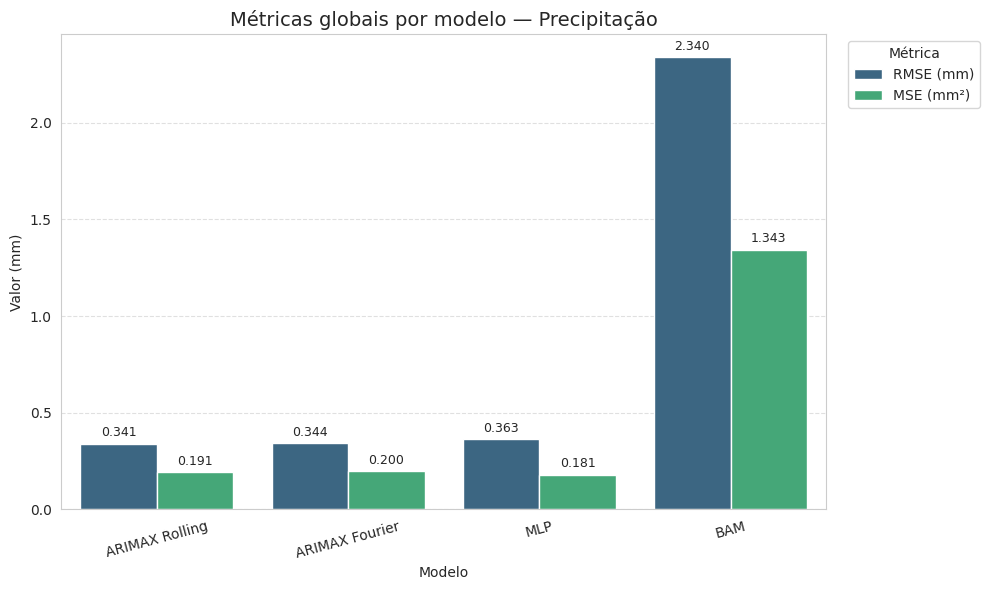

Métricas globais por modelo (RMSE e MAE):
        Modelo  RMSE (mm)  MSE (mm²)
ARIMAX Rolling      0.341      0.191
ARIMAX Fourier      0.344      0.200
           MLP      0.363      0.181
           BAM      2.340      1.343


/tmp/ipykernel_4097/1275129085.py:228: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=smape_df, x='Modelo', y='sMAPE (%)', palette='mako')


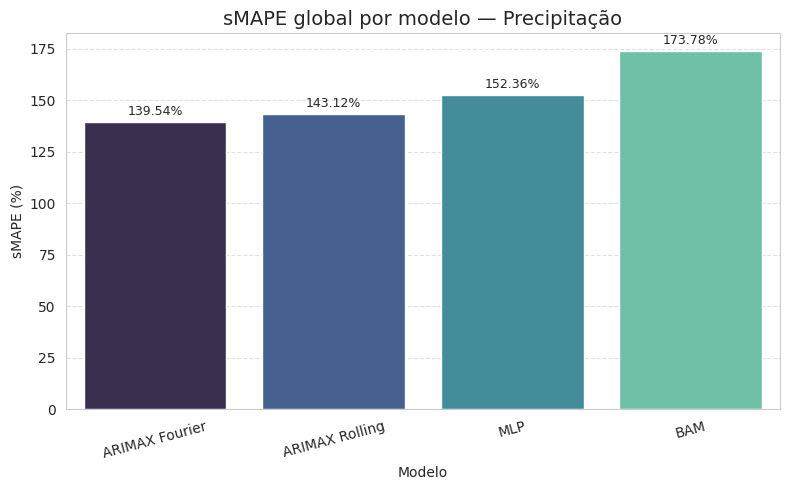

sMAPE global por modelo (%):
        Modelo  sMAPE (%)
ARIMAX Fourier    139.540
ARIMAX Rolling    143.118
           MLP    152.363
           BAM    173.775


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.dates as mdates
from functools import reduce

sns.set_style("whitegrid")

# Leitura dos dados
df_bam      = pd.read_csv('bam_data_precipitacao.csv', sep=';')
df_fourier  = pd.read_csv('forecast_arima_fourier_precipitacao.csv', sep=';')
df_rolling  = pd.read_csv('forecast_arima_rolling_precipitacao.csv', sep=';')
df_mlp      = pd.read_csv('forecast_MLP_rain.csv', sep=';')

#  Processar BAM (média diária)
df_bam['time'] = pd.to_datetime(df_bam['time'])
df_bam['date'] = df_bam['time'].dt.date
df_bam_daily = (
    df_bam.groupby('date', as_index=False)['precip']
          .mean()
          .rename(columns={'precip': 'precipitacao_bam'})
)

# Função utilitária p/ processar previsões
def daily_from_forecast_csv(df, prefix):
    df = df.copy()
    df['date'] = pd.to_datetime(df['data']).dt.date
    return (
        df.groupby('date', as_index=False)[['precipitacao_observada', 'precipitacao_prevista']]
          .mean()
          .rename(columns={
              'precipitacao_observada': f'precipitacao_observada_{prefix}',
              'precipitacao_prevista':  f'precipitacao_prevista_{prefix}'
          })
    )

df_fourier_daily       = daily_from_forecast_csv(df_fourier,       'fourier')
df_fourier_exog_daily  = daily_from_forecast_csv(df_fourier_exog,  'fourierexog')
df_rolling_daily       = daily_from_forecast_csv(df_rolling,       'rolling')
df_mlp_daily           = daily_from_forecast_csv(df_mlp,           'mlp')

# Merge de previsões e definição do observado
dfs_pred = [df_fourier_daily, df_fourier_exog_daily, df_rolling_daily, df_mlp_daily]
df_pred = reduce(lambda l, r: pd.merge(l, r, on='date', how='outer'), dfs_pred)

# Escolhe a coluna "observada" disponível 
df_pred['precipitacao_observada'] = np.nan
for col in [
    'precipitacao_observada_fourier',
    'precipitacao_observada_rolling',
    'precipitacao_observada_mlp'
]:
    if col in df_pred.columns:
        df_pred['precipitacao_observada'] = df_pred['precipitacao_observada'].fillna(df_pred[col])

df_pred = df_pred[['date', 'precipitacao_observada',
                   'precipitacao_prevista_fourier',
                   'precipitacao_prevista_rolling',
                   'precipitacao_prevista_mlp']]

# Merge com dados BAM
df_merged = (pd.merge(df_bam_daily, df_pred, on='date', how='inner')
               .dropna()
               .sort_values('date'))
df_merged['date'] = pd.to_datetime(df_merged['date'])

# Cálculo do RMSE por modelo
model_cols = {
    'BAM': 'precipitacao_bam',
    'ARIMAX Fourier': 'precipitacao_prevista_fourier',
    'ARIMAX Rolling': 'precipitacao_prevista_rolling',
    'MLP': 'precipitacao_prevista_mlp'
}

metrics = []
for name, col in model_cols.items():
    y_true = df_merged['precipitacao_observada']
    y_pred = df_merged[col]
    metrics.append({
        'Modelo': name,
        'RMSE (mm)': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MSE (mm²)': mean_absolute_error(y_true, y_pred),
        'R2': r2_score(y_true, y_pred)
    })
metrics_df = pd.DataFrame(metrics).sort_values('RMSE (mm)')

# Gráficos de dispersão 
fig, axs = plt.subplots(3, 2, figsize=(16, 18), sharex=True)
ax = axs.ravel()

def linepair(axi, y_pred_col, label_pred, rmse):
    sns.lineplot(x='date', y='precipitacao_observada', data=df_merged, ax=axi, label='Observada')
    sns.lineplot(x='date', y=y_pred_col,                 data=df_merged, ax=axi, label=label_pred)
    axi.set_xlabel('Data'); axi.set_ylabel('Precipitação (mm)')
    axi.set_title(f'{label_pred} vs Observada\RMSE (mm) = {rmse:.2f} mm')
    axi.grid(True); axi.legend(loc='upper left')

linepair(ax[0], 'precipitacao_bam',                  'BAM',                         metrics_df.set_index('Modelo').loc['BAM','RMSE (mm)'])
linepair(ax[1], 'precipitacao_prevista_fourier', 'ARIMAX Fourier', metrics_df.set_index('Modelo').loc['ARIMAX Fourier','RMSE (mm)'])
linepair(ax[2], 'precipitacao_prevista_rolling',     'ARIMAX Rolling',              metrics_df.set_index('Modelo').loc['ARIMAX Rolling','RMSE (mm)'])
linepair(ax[3], 'precipitacao_prevista_mlp',         'MLP',                         metrics_df.set_index('Modelo').loc['MLP','RMSE (mm)'])
ax[5].axis('off')

for i in range(5):
    axi = ax[i]
    axi.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
    axi.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    for lbl in axi.get_xticklabels():
        lbl.set_rotation(45); lbl.set_horizontalalignment('right')

plt.suptitle('Comparação de Precipitação: Observada × Modelos', fontsize=18, y=0.98)
plt.tight_layout(rect=[0, 0.02, 1, 0.96])
plt.show()


# Erro absoluto ao longo do tempo (média móvel)
roll_w = 30  # janela em dias 
plt.figure(figsize=(12,5))
for name, col in model_cols.items():
    err_abs = (df_merged[col] - df_merged['precipitacao_observada']).abs()
    plt.plot(df_merged['date'], err_abs.rolling(roll_w, min_periods=1).mean(), label=name)
plt.title(f'Erro absoluto (média móvel {roll_w} dias) - Precipitação')
plt.xlabel('Data'); plt.ylabel('|Erro| (mm)')
plt.legend(); plt.grid(True)
plt.tight_layout(); plt.show()

# Distribuição mensal dos resíduos (boxplot)
df_merged['month'] = df_merged['date'].dt.month
resid_long = []
for name, col in model_cols.items():
    resid_long.append(pd.DataFrame({
        'Modelo': name,
        'Mês': df_merged['month'],
        'Resíduo': df_merged[col] - df_merged['precipitacao_observada']
    }))
resid_long = pd.concat(resid_long, ignore_index=True)

plt.figure(figsize=(14,6))
sns.boxplot(data=resid_long, x='Mês', y='Resíduo', hue='Modelo', showfliers=False)
plt.axhline(0, ls='--', c='k', lw=1)
plt.title('Distribuição mensal dos resíduos por modelo - Precipitação')
plt.ylabel('Resíduo (mm)')
plt.tight_layout(); plt.show()



# Métricas globais por modelo — gráfico único com valores
if 'R2' in metrics_df.columns:
    metrics_df = metrics_df.drop(columns=['R2'])

# reorganiza métricas (RMSE e MSE)
metrics_long = metrics_df.melt(id_vars='Modelo', 
                               var_name='Métrica', 
                               value_name='Valor')

# cria gráfico de barras 
plt.figure(figsize=(10,6))
ax = sns.barplot(data=metrics_long, x='Modelo', y='Valor', hue='Métrica', palette='viridis')

plt.title('Métricas globais por modelo — Precipitação', fontsize=14)
plt.xlabel('Modelo')
plt.ylabel('Valor (mm)')
plt.xticks(rotation=15)
plt.legend(title='Métrica', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.grid(True, axis='y', linestyle='--', alpha=0.6)

for container in ax.containers:
    ax.bar_label(container, fmt="%.3f", padding=3, fontsize=9)

plt.tight_layout()
plt.show()

print("Métricas globais por modelo (RMSE e MAE):")
print(metrics_df.to_string(index=False, float_format="%.3f"))


# Gráfico sMAPE (%) por modelo

# função sMAPE
def smape(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    denom = np.abs(y_true) + np.abs(y_pred)
    diff = np.abs(y_pred - y_true)
    with np.errstate(divide='ignore', invalid='ignore'):
        frac = np.where(denom == 0, 0.0, diff / denom)
    return 200.0 * np.nanmean(frac)  # percentual (%)

# cálculo do sMAPE para cada modelo
smape_vals = []
for nome, col in model_cols.items():
    y_true = df_merged['precipitacao_observada']
    y_pred = df_merged[col]
    smape_vals.append({'Modelo': nome, 'sMAPE (%)': smape(y_true, y_pred)})

smape_df = pd.DataFrame(smape_vals).sort_values('sMAPE (%)')

# gráfico de barras
plt.figure(figsize=(8, 5))
ax = sns.barplot(data=smape_df, x='Modelo', y='sMAPE (%)', palette='mako')

plt.title('sMAPE global por modelo — Precipitação', fontsize=14)
plt.ylabel('sMAPE (%)')
plt.xlabel('Modelo')
plt.xticks(rotation=15)
plt.grid(True, axis='y', linestyle='--', alpha=0.6)

for container in ax.containers:
    ax.bar_label(container, fmt="%.2f%%", padding=3, fontsize=9)

plt.tight_layout()
plt.show()

print("sMAPE global por modelo (%):")
print(smape_df.to_string(index=False, float_format="%.3f"))


Benchmark Umidade

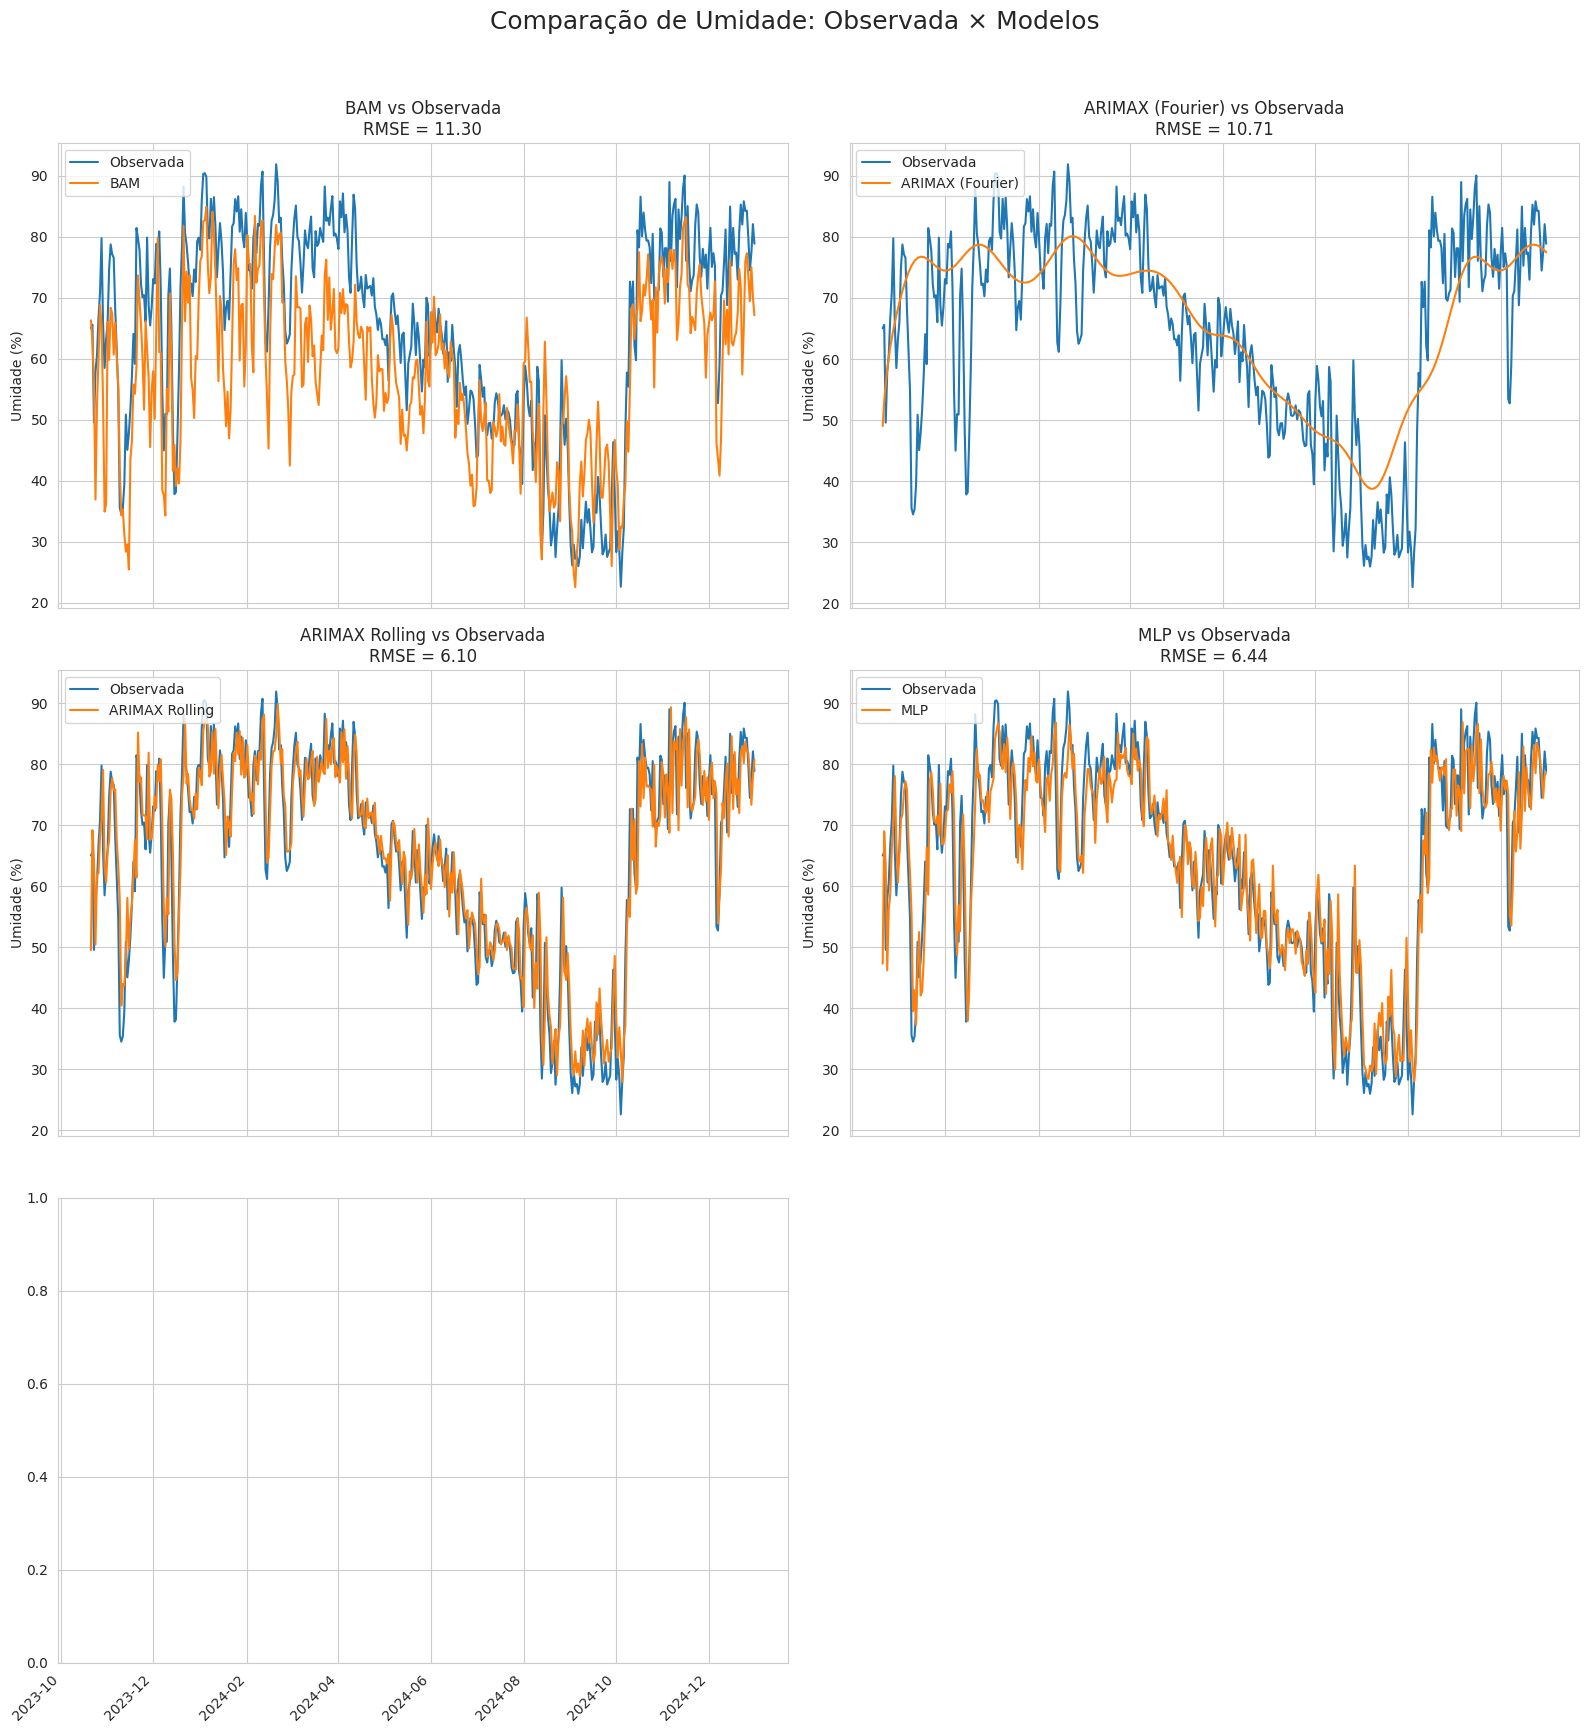

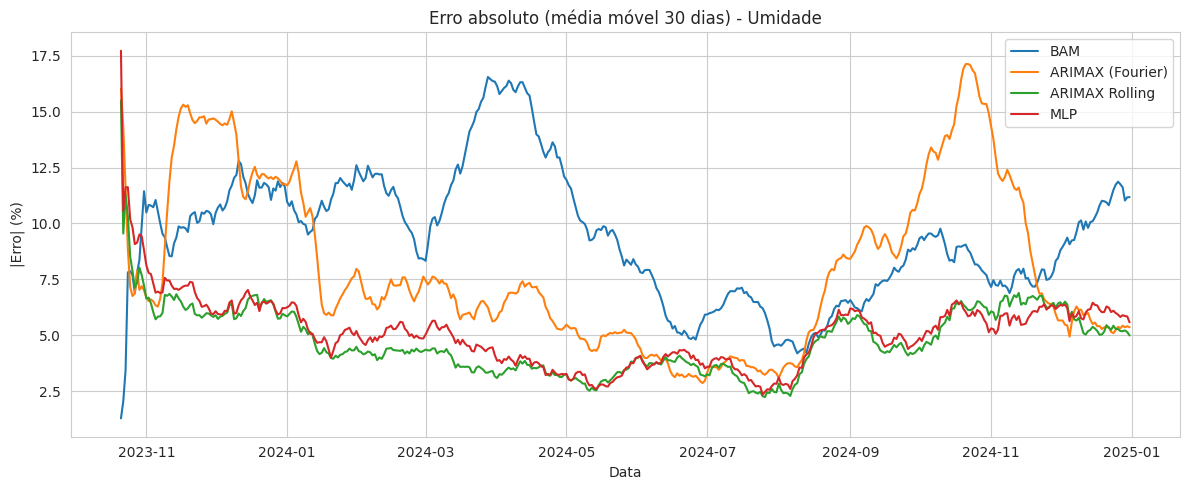

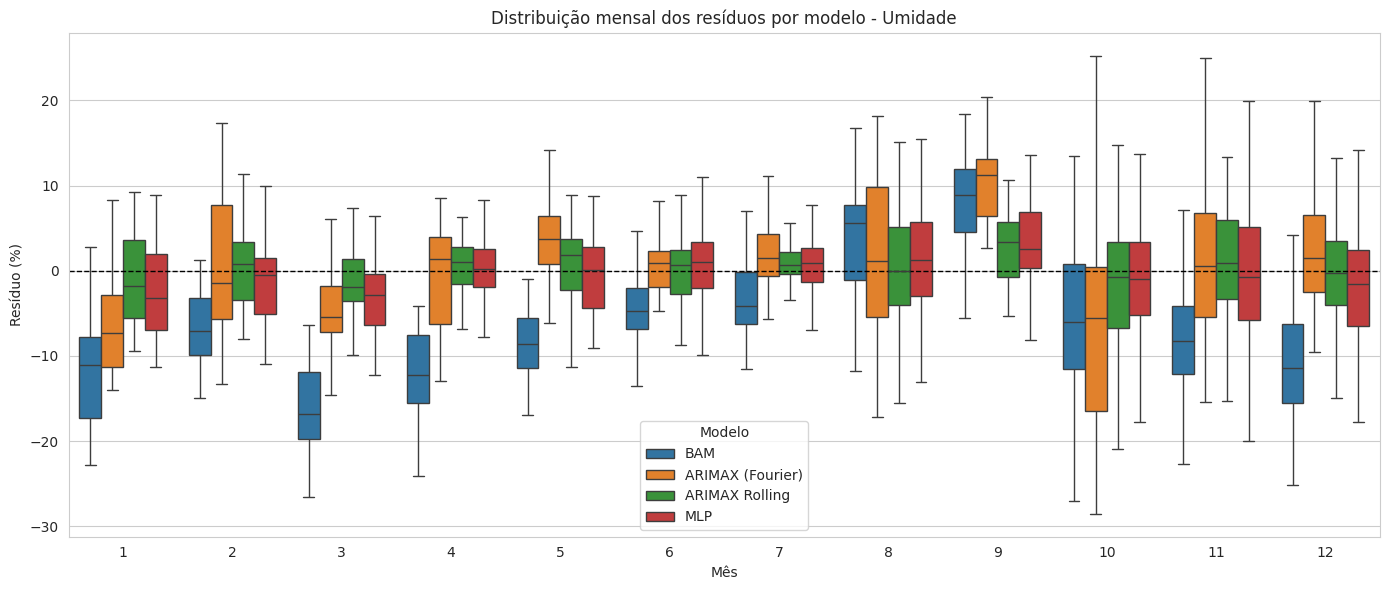

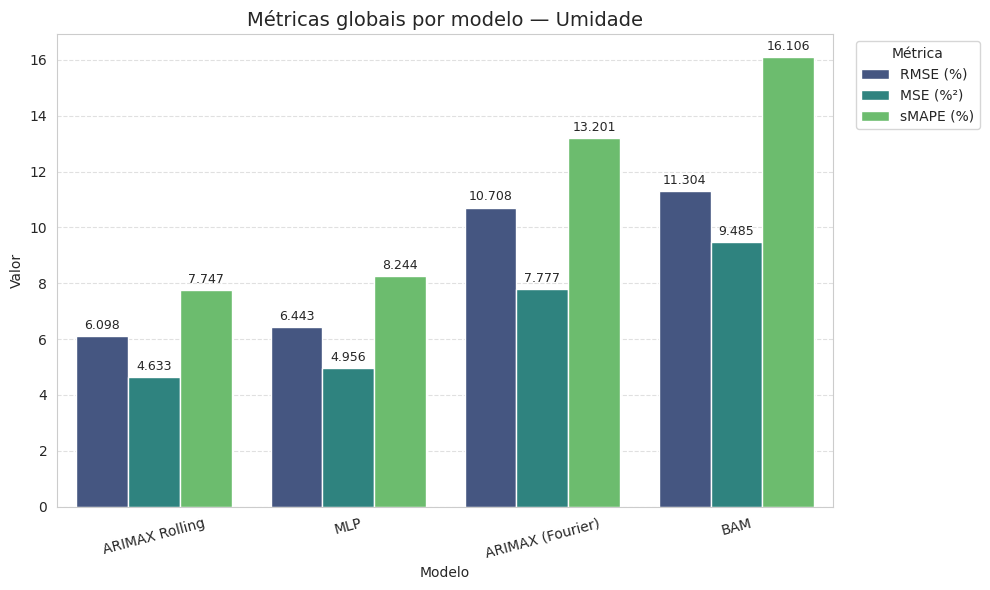

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.dates as mdates
from functools import reduce

sns.set_style("whitegrid")

# Leitura dos dados

df_bam      = pd.read_csv('bam_data_umidade.csv', sep=';')
df_fourier  = pd.read_csv('forecast_arima_fourier_umidade.csv', sep=';')
df_rolling  = pd.read_csv('forecast_arima_rolling_umidade.csv', sep=';')
df_mlp      = pd.read_csv('forecast_MLP_umidade.csv', sep=';')

#  Processar BAM (média diária)
df_bam['time'] = pd.to_datetime(df_bam['time'])
df_bam['date'] = df_bam['time'].dt.date
df_bam_daily = (
    df_bam.groupby('date', as_index=False)['rh']
          .mean()
          .rename(columns={'rh': 'umidade_bam'})
)

# Função utilitária p/ processar previsões
def daily_from_forecast_csv(df, prefix):
    df = df.copy()
    df['date'] = pd.to_datetime(df['data']).dt.date
    return (
        df.groupby('date', as_index=False)[['umidade_observada', 'umidade_prevista']]
          .mean()
          .rename(columns={
              'umidade_observada': f'umidade_observada_{prefix}',
              'umidade_prevista':  f'umidade_prevista_{prefix}'
          })
    )

df_fourier_daily       = daily_from_forecast_csv(df_fourier,       'fourier')
df_rolling_daily       = daily_from_forecast_csv(df_rolling,       'rolling')
df_mlp_daily           = daily_from_forecast_csv(df_mlp,           'mlp')

# Merge de previsões e definição do observado
dfs_pred = [df_fourier_daily, df_rolling_daily, df_mlp_daily]
df_pred = reduce(lambda l, r: pd.merge(l, r, on='date', how='outer'), dfs_pred)

# escolhe a coluna "observada" disponível
df_pred['umidade_observada'] = np.nan
for col in [
    'umidade_observada_fourier',
    'umidade_observada_rolling',
    'umidade_observada_mlp'
]:
    if col in df_pred.columns:
        df_pred['umidade_observada'] = df_pred['umidade_observada'].fillna(df_pred[col])

df_pred = df_pred[['date', 'umidade_observada',
                   'umidade_prevista_fourier',
                   'umidade_prevista_rolling',
                   'umidade_prevista_mlp']]

# Merge com dados BAM
df_merged = (pd.merge(df_bam_daily, df_pred, on='date', how='inner')
               .dropna()
               .sort_values('date'))
df_merged['date'] = pd.to_datetime(df_merged['date'])

# Cálculo métricas por modelo
model_cols = {
    'BAM': 'umidade_bam',
    'ARIMAX (Fourier)': 'umidade_prevista_fourier',
    'ARIMAX Rolling': 'umidade_prevista_rolling',
    'MLP': 'umidade_prevista_mlp'
}

metrics = []
for name, col in model_cols.items():
    y_true = df_merged['umidade_observada']
    y_pred = df_merged[col]
    metrics.append({
        'Modelo': name,
        'RMSE (%)': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MSE (%²)': mean_absolute_error(y_true, y_pred),
        'R2': r2_score(y_true, y_pred)
    })
metrics_df = pd.DataFrame(metrics).sort_values('RMSE (%)')

# Gráficos de dispersão 
fig, axs = plt.subplots(3, 2, figsize=(16, 18), sharex=True)
ax = axs.ravel()

def linepair(axi, y_pred_col, label_pred, rmse):
    sns.lineplot(x='date', y='umidade_observada', data=df_merged, ax=axi, label='Observada')
    sns.lineplot(x='date', y=y_pred_col,                 data=df_merged, ax=axi, label=label_pred)
    axi.set_xlabel('Data'); axi.set_ylabel('Umidade (%)')
    axi.set_title(f'{label_pred} vs Observada\nRMSE = {rmse:.2f}')
    axi.grid(True); axi.legend(loc='upper left')

linepair(ax[0], 'umidade_bam',                  'BAM',                         metrics_df.set_index('Modelo').loc['BAM','RMSE (%)'])
linepair(ax[1], 'umidade_prevista_fourier',     'ARIMAX (Fourier)',            metrics_df.set_index('Modelo').loc['ARIMAX (Fourier)','RMSE (%)'])
linepair(ax[2], 'umidade_prevista_rolling',     'ARIMAX Rolling',              metrics_df.set_index('Modelo').loc['ARIMAX Rolling','RMSE (%)'])
linepair(ax[3], 'umidade_prevista_mlp',         'MLP',                         metrics_df.set_index('Modelo').loc['MLP','RMSE (%)'])
ax[5].axis('off')

for i in range(5):
    axi = ax[i]
    axi.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
    axi.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    for lbl in axi.get_xticklabels():
        lbl.set_rotation(45); lbl.set_horizontalalignment('right')

plt.suptitle('Comparação de Umidade: Observada × Modelos', fontsize=18, y=0.98)
plt.tight_layout(rect=[0, 0.02, 1, 0.96])
plt.show()


# Erro absoluto ao longo do tempo (média móvel)
roll_w = 30  # dias
plt.figure(figsize=(12,5))
for name, col in model_cols.items():
    err_abs = (df_merged[col] - df_merged['umidade_observada']).abs()
    plt.plot(df_merged['date'], err_abs.rolling(roll_w, min_periods=1).mean(), label=name)
plt.title(f'Erro absoluto (média móvel {roll_w} dias) - Umidade')
plt.xlabel('Data'); plt.ylabel('|Erro| (%)')
plt.legend(); plt.grid(True)
plt.tight_layout(); plt.show()

# Distribuição mensal dos resíduos (boxplot)
df_merged['month'] = df_merged['date'].dt.month
resid_long = []
for name, col in model_cols.items():
    resid_long.append(pd.DataFrame({
        'Modelo': name,
        'Mês': df_merged['month'],
        'Resíduo': df_merged[col] - df_merged['umidade_observada']
    }))
resid_long = pd.concat(resid_long, ignore_index=True)

plt.figure(figsize=(14,6))
sns.boxplot(data=resid_long, x='Mês', y='Resíduo', hue='Modelo', showfliers=False)
plt.axhline(0, ls='--', c='k', lw=1)
plt.title('Distribuição mensal dos resíduos por modelo - Umidade')
plt.ylabel('Resíduo (%)')
plt.tight_layout(); plt.show()


# Métricas globais por modelo — gráfico único com valores
if 'R2' in metrics_df.columns:
    metrics_df = metrics_df.drop(columns=['R2'])

def smape(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    denom = np.abs(y_true) + np.abs(y_pred)
    diff = np.abs(y_pred - y_true)
    with np.errstate(divide='ignore', invalid='ignore'):
        frac = np.where(denom == 0, 0.0, diff / denom)
    return 200.0 * np.nanmean(frac)  # %

smape_vals = []
for nome, col in model_cols.items():
    y_true = df_merged['umidade_observada']
    y_pred = df_merged[col]
    smape_vals.append({'Modelo': nome, 'sMAPE (%)': smape(y_true, y_pred)})

smape_df = pd.DataFrame(smape_vals)
metrics_df = metrics_df.merge(smape_df, on='Modelo', how='left')

# Plot grafico de barras
hue_order = ['RMSE (%)', 'MSE (%²)', 'sMAPE (%)']  # ordem das métricas na legenda
metrics_long = metrics_df.melt(id_vars='Modelo',
                               value_vars=hue_order,
                               var_name='Métrica',
                               value_name='Valor')

plt.figure(figsize=(10, 6))
ax = sns.barplot(data=metrics_long, x='Modelo', y='Valor',
                 hue='Métrica', hue_order=hue_order, palette='viridis')

plt.title('Métricas globais por modelo — Umidade', fontsize=14)
plt.xlabel('Modelo')
plt.ylabel('Valor')
plt.xticks(rotation=15)
plt.legend(title='Métrica', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.grid(True, axis='y', linestyle='--', alpha=0.6)

for container, metrica in zip(ax.containers, hue_order):
    unidade = '' if metrica in ('RMSE (%)', 'MSE (%²)') else ''
    labels = [f"{bar.get_height():.3f}{unidade}" for bar in container]
    ax.bar_label(container, labels=labels, padding=3, fontsize=9)

plt.tight_layout()
plt.show()



